### Strand Classifier Using one Minhash Function
* A single threaded implementation of Strand as a SciKit Estimator using **only one** hashing functions. 

**This notebook shows performance differences using:**
* A single minhash function.
* Stratified Cross Validation using only one fold with an 80 / 20 split.
* 10-fold Stratified Cross Validation using 90 / 10 splits.
* Total classes: 64
* Longest sequence in file: 1,834  
* File Sequence Count: 4,786
* Input file size of 14,365 KB

**Observations:**
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=100) = 4.09 sec, 99.3% Accuracy
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=60, minhash_length=100) = 4.08 sec, 99.2% Accuracy 
* 10-Fold stratified cv @ 90 / 10 splits and (kmer_length=31, minhash_length=100) = 11.6 sec, 99.5% Accuracy 

In [17]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

In [18]:
# Created by Jake Drew on 03/16/2020
# All rights reserved - 03/2020
class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_stores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_stores, key=category_stores.get)
            #Add to our predictions
            yhats.append(winning_category)
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += 1
        return class_scores
    

## Cross Validation

In [1]:
def read_fasta_file(file_path):
    X = []
    y = []
    with open(file_path, 'r') as dat:
        for line in dat.readlines():
            #print(line)
            if line[0] == '>':
                g_start = line.find("g__")
                g_end = line.find(";", g_start)
                genus = line[g_start:g_end]
                y.append(genus)
            else:
                X.append(line)
    return X, y

In [2]:
import pandas as pd

# Read in the fasta file
X, y = read_fasta_file('D:/StrandPy/Data/RDP_All_Clean.strand')
#Remove low count genera that halt cross validation
data = {'X': X,'y':y}
df = pd.DataFrame(data)

In [3]:
#Inspect counts for each class
vcts = df.y.value_counts()
low_vcts = vcts[vcts < 20].index.values

In [4]:
#Remove low count genera. Any classes < the fold count will halt cross validation
df = df[~df.y.isin(low_vcts)]
df.y.value_counts()

g__Streptomycineae                     544
g__Micrococcineae                      488
g__Corynebacterineae                   401
g__Pseudonocardineae                   192
g__Streptosporangineae                 188
g__Bacillus                            177
g__Lactobacillus                       159
g__Pseudomonas                         136
g__Clostridium_sensu_stricto           130
g__Micromonosporineae                  129
g__Paenibacillus                       126
g__Propionibacterineae                 125
g__Mycoplasma                          114
g__Shewanella                           84
g__Vibrio                               77
g__Streptococcus                        76
g__Halomonas                            64
g__Flavobacterium                       63
g__Staphylococcus                       62
g__Burkholderia                         58
g__Sphingomonas                         57
g__Desulfovibrio                        55
g__Chryseobacterium                     54
g__Actinomy

In [5]:
X = df.X.values
y = df.y.values

In [6]:
print('File Size: ' + str(len(X)))

File Size: 4786


In [7]:
print('Longest Sequence Chars:' + str(len(max(X, key=len))))

Longest Sequence Chars:1834


In [25]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

def per_class_accuracy(ytrue,yhat):
    conf = confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title='',class_list=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel(class_list)
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100* accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

## Test at kmer_length=31, minhash_length=100,

In [26]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=100, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 4.09 s


                                     precision    recall  f1-score   support

                   g__Acinetobacter      1.000     1.000     1.000         5
                  g__Actinomycineae      1.000     1.000     1.000        11
                       g__Aeromonas      1.000     1.000     1.000         7
                g__Alicyclobacillus      1.000     1.000     1.000         5
 g__Armatimonas/Armatimonadetes_gp1      1.000     1.000     1.000         6
                        g__Bacillus      0.973     1.000     0.986        36
                     g__Bacteroides      0.889     1.000     0.941         8
                      g__Bartonella      1.000     1.000     1.000         5
              g__Bifidobacteriaceae      1.000     1.000     1.000        10
                   g__Brevundimonas      1.000     1.000     1.000         5
                    g__Burkholderia      1.000     1.000     1.000        12
                   g__Campylobacter      1.000     1.000     1.000         

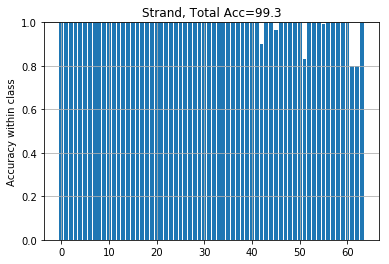

In [27]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=60, minhash_length=100,

In [28]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=60, minhash_length=100, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 4.08 s


                                     precision    recall  f1-score   support

                   g__Acinetobacter      1.000     1.000     1.000         5
                  g__Actinomycineae      1.000     1.000     1.000        11
                       g__Aeromonas      1.000     1.000     1.000         7
                g__Alicyclobacillus      0.833     1.000     0.909         5
 g__Armatimonas/Armatimonadetes_gp1      1.000     1.000     1.000         6
                        g__Bacillus      0.972     0.972     0.972        36
                     g__Bacteroides      1.000     1.000     1.000         8
                      g__Bartonella      1.000     1.000     1.000         5
              g__Bifidobacteriaceae      1.000     1.000     1.000        10
                   g__Brevundimonas      1.000     1.000     1.000         5
                    g__Burkholderia      1.000     1.000     1.000        12
                   g__Campylobacter      1.000     1.000     1.000         

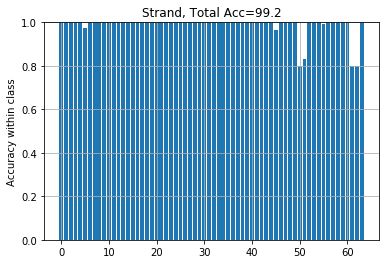

In [29]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Parallel 10-Fold CV at kmer_length=30, minhash_length=100,

In [30]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

# Create our Strand sequence classifier
strand = StrandClassifierV2(kmer_length=31, minhash_length=100, random_state=42)

#run in parallel on all available cores
yhat = cross_val_predict(strand, X, y, cv=cv, n_jobs=-1)

Wall time: 11.6 s


                                     precision    recall  f1-score   support

                   g__Acinetobacter      1.000     1.000     1.000        22
                  g__Actinomycineae      1.000     1.000     1.000        54
                       g__Aeromonas      1.000     1.000     1.000        33
                g__Alicyclobacillus      1.000     0.952     0.976        21
 g__Armatimonas/Armatimonadetes_gp1      1.000     1.000     1.000        29
                        g__Bacillus      0.989     1.000     0.994       177
                     g__Bacteroides      0.974     1.000     0.987        37
                      g__Bartonella      1.000     1.000     1.000        24
              g__Bifidobacteriaceae      1.000     1.000     1.000        47
                   g__Brevundimonas      1.000     1.000     1.000        21
                    g__Burkholderia      1.000     1.000     1.000        58
                   g__Campylobacter      1.000     1.000     1.000        2

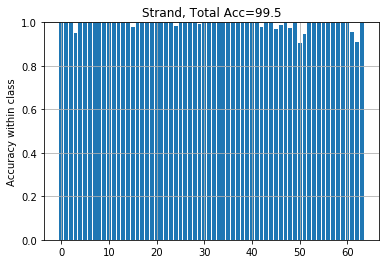

In [31]:
# Report our results
print (classification_report(y, yhat, digits = 3))
                
plot_class_acc(y, yhat, title = "Strand", class_list = '')